In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Importing the libraries 
import torch
import torchvision
import torchaudio
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import matplotlib.cm as cm
import pandas as pd
import os
import librosa
import librosa.display
import torch.nn.functional as F
from torch.autograd import Variable
import time
from Models import Autoencoder
from TestData import SingleMus
from Data_TIMIT import Data_TIMIT
import IPython.display as ipd
from IPython.display import clear_output
from Blocks import BasicBlock, Bottleneck
from EntropyControl import AE_control
from Pure_coding import Pure_Coding

# Checking the availability of CUDA on machine
# print("Torch", torch.__version__, "CUDA", torch.version.cuda)
# print("Device:", torch.device("cuda:1"))
# print(torch.cuda.is_available())



/media/sdb1/hy17/venv/lib/python3.6/site-packages/numba/errors.py:131: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


## Data Preparation

- #### TIMIT Data

In [2]:
# overlap = 64
# data = Data_TIMIT('test', overlap = overlap)
# test_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle \
#                                            = True, num_workers = 4)

# torch.save(test_loader, 'data/half_win_test_ctn_new.pth')

In [3]:
# data = Data_TIMIT('train', mix_num = 1)
# train_loader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle \
#                                            = True, num_workers = 4)
# torch.save(train_loader, 'data/half_win_train_ctn_new.pth')

In [4]:
train_loader = torch.load('data/half_win_train_ctn_std_m.pth')
test_loader = torch.load('data/half_win_test_ctn_std_m.pth')

In [5]:
print(len(train_loader),len(test_loader))

3000 300


In [6]:
# for c, x, c_l, x_l in test_loader:
#     break
# print(c.shape)
# print(x.shape)
# print(c_l.shape)
# print(x_l.shape)

In [7]:
# ipd.Audio(rebuild(mixture[0].cpu().data.numpy()), rate = 16000)

In [8]:
# SISDR(source, mixture)

#### Dummy testing, for easy running

Test on whole wavefiles - able to be rebuild

In [9]:
def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()

def SDR(s, sr, cuda = False): # input (50, 512), (50, 512)
    
    eps=1e-20
    sdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    
    if cuda:
        return sdr
    else:
        return sdr.cpu().data.numpy()
    
def melMSELoss(s, sr): # input waveform(torch.Tensor)
    
    n_mels = [8, 16, 32, 128]
    loss = 0
    eps = 1e-20
    mse = nn.MSELoss()
    for n in n_mels:
        s_mel = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n)(s)
        sr_mel = torchaudio.transforms.MelSpectrogram(n_fft=512, n_mels=n)(sr)
        s_mel = torch.log(s_mel + eps)
        sr_mel = torch.log(sr_mel + eps)
        m = mse(s_mel, sr_mel)
        loss += m
    return loss/len(n_mels)


def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
#         print(i)
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def test_qtz(soft):
#     model.eval()
    sdr_list_s = []
    sdr_list_n = []
    i = 0

    for source, mixture in test_loader:
        source = source[0]
        mixture = mixture[0]
#         print(data)
#         print(i)
#         i+=1
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        target = source
        
        s_h, n_h, arg_s, arg_n = model(mixture, soft)
        # arg will be None when doing softquantization

        sdr_list_s.append(SDR(source, s_h))
        sdr_list_n.append(SDR(noise, n_h))
        
    s_score = np.mean(sdr_list_s) 
    n_score = np.mean(sdr_list_n) 
    
    return s_score, n_score, arg_s, arg_n


def test_no_qtz():
#     model.eval()
    sdr_list_s = []
    sdr_list_n = []
    i = 0
    for source, mixture in test_loader:
        source = source[0]
        mixture = mixture[0]
#         print(data)
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        s_h, n_h = model.test_no_qtz(mixture)
#         print(outputs)

    sdr_list_s.append(SDR(source, s_h))    
    sdr_list_n.append(SDR(noise, n_h))
        
    
    s_score = np.mean(sdr_list_s) 
    n_score = np.mean(sdr_list_n)
    
    return s_score, n_score

def test_newData(soft):
#     model.eval()
    sdr_list_s = []
    sdr_list_n = []
    sdr_list_rs = []
    sdr_list_rx = []
    sdr_list_diff = []
    entp_list = []
    max_rs_sdr = 0
    max_rx_sdr = 0
    max_rs = None
    max_rx = None
    i = 0
    for wave_s, wave_x, source, mixture in test_loader: 
#         torch.Size([1, 50688])
#         torch.Size([1, 50688])
#         torch.Size([1, 113, 512])
#         torch.Size([1, 113, 512])
        source = source[0]
        mixture = mixture[0]
#         print(data)
        noise = (mixture-source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()
        s_h,arg_s = model(mixture, soft=soft)
        
#         if not isinstance(arg_s, type(None)):
#             entp = cal_entropy(arg_s)
#             entp_list.append(entp)
#             print(entp)
# #         print(outputs)

        sdr_list_s.append(SISDR(mixture, s_h))    
        
        rs = rebuild(s_h).unsqueeze(dim = 0)
        
        rs_sdr = SISDR(wave_x, rs)
        sdr_list_rs.append(rs_sdr)
        
        if max_rs_sdr < rs_sdr:
            max_rs_sdr = rs_sdr
            max_rs = (wave_x, rs)
    
    s_score = np.mean(sdr_list_s) 
#     n_score = np.mean(sdr_list_n)
    rs_score = np.mean(sdr_list_rs)
    
    return s_score, rs_score, max_rs, arg_s


import collections

def cal_entropy(arg):
    
    entropy = 0
    eps = 1e-20
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
        
    return entropy

def entropy_prob(prob): # prob (bs, 512, num_m)
    
    entropy = 0
    eps = 1e-20
    prob_counter = torch.sum(prob, dim=0)
    prob_counter = torch.sum(prob_counter, dim=0)
    assert len(prob_counter) == prob.shape[-1]
    prob_counter = prob_counter / sum(prob_counter)
    entropy = - torch.sum(torch.log(prob_counter+eps)*prob_counter)
#     sum_v = sum(prob_counter)
#     for value in prob_counter:
#         p = value / sum_v
#         entropy += -torch.log(p+eps)*p
    
    return entropy
        
        


## Model Define

In [14]:

model = Pure_Coding(block = BasicBlock, d = 1, filters = 30, num_m = 128, scale = 10,\
                    ds = False,trans = False).cuda()
# print(model.code.is_leaf)
lr = 0.0001
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(list(model.parameters()) + [model.means], lr=lr) \
#                              ,betas = (0.9, 0.99999))
# optimizer = torch.optim.Adam(list(model.parameters()) , lr=lr) \
#                              ,betas = (0.9, 0.99999))
#                              weight_decay=1e-5)

run block


## Train

no sp<br>
control entrop on 2

In [15]:
epochs = 100
epoch_list = []
max_sdr = 0
max_rs = None
max_rx = None
target_entp = 1
target_range = 0.2
itermax = 0
etp = 0
t = 0
# model.stage = 1

In [16]:

while 1:
    control = 0
    start = time.time()
    model.train()
    if t == 1:
        model.stage = 1
    if model.scale < 500:
        model.scale *= t+1
    train_sdr_s = []
    train_entp = []
    
    for wave_s, wave_x, source, mixture in train_loader:
        
        source = source[0]
        mixture = mixture[0]
        
        noise = (mixture - source).cuda()
        source = source.cuda()
        mixture = mixture.cuda()

#         s_h, n_h, _, _  = model.forward_sep(mixture, soft = True)
        output, prob = model(mixture, soft = True)
        # prob.shape == (bs, L, num_m)
        
    
        rs = rebuild(output).unsqueeze(dim = 0)
        
        entp = None
        if not isinstance(prob, type(None)):
            entp = entropy_prob(prob)
            train_entp.append(entp.cpu().data.numpy())
        
        train_sdr_s.append(SISDR(mixture, output))
#         train_melmse.append(melMSELoss(rs, wave_x).cpu().data.numpy())
        
#         print('haha')
        optimizer.zero_grad()
        loss = criterion(output, mixture)
        if model.stage == 1 and not isinstance(entp, type(None)) \
        and abs(entp - target_entp) > target_range and etp == 1:
            control = 1
            loss = criterion(output, mixture) + 1/50*(target_entp - entp)**2
        loss.backward()
#         print(list(model.code.grad))
        optimizer.step()

    end = time.time()
    print('epoch_{}| Time:{:.0f}'.format(t, end-start))
#     print('loss: {:.3f}'.format(loss.data.cpu().numpy()), 'Time: {:.0f}'.format(end-start))
    
#     s_score_soft, n_score_soft, _, _ = test_qtz(soft = True)
#     s_score_hard, n_score_hard, arg_s, arg_n = test_qtz(soft = False)
    
#     soft_score, soft_r_score, _, _ = test_newData(soft = True)
    hard_score, hard_r_score, max_singel_rs, arg_s = test_newData(soft = False)
    
    entp = 0
    if not isinstance(arg_s, type(None)):
        entp = cal_entropy(arg_s.flatten().cpu().data.numpy())

    print('train- s: {:.2f}, entropy:{:.2f}, control:{} \nTest- hard_s: {:.2f}, hard_rs: {:.2f}| Entropy : {:.2f}'\
          .format(np.mean(train_sdr_s), np.mean(train_entp), control,  hard_score, hard_r_score, entp))
 
    t += 1
    if model.stage == 1:
#         etp = 1
        itermax += 1
        if hard_score > max_sdr:
            max_sdr = hard_score
            max_rs = max_singel_rs
            itermax = 0
#             torch.save(model, '0330_mask_coding_DOWN.model')  
    
    if etp == 0 and itermax >= 3:
        etp = 1
        max_sdr = 0
        itermax = 0
    
    if etp == 1 and itermax >= 10:
#     if itermax >= 10:
        print('over')
        break
        
        
    


epoch_0| Time:98
train- s: 17.10, entropy:nan, control:0 
Test- hard_s: 26.64, hard_rs: 24.83| Entropy : 0.00
epoch_1| Time:184
train- s: 19.10, entropy:4.76, control:0 
Test- hard_s: -6.59, hard_rs: -4.83| Entropy : 3.01
epoch_2| Time:187
train- s: 22.71, entropy:4.77, control:0 
Test- hard_s: -1.04, hard_rs: 1.35| Entropy : 3.36
epoch_3| Time:179
train- s: 22.17, entropy:4.50, control:0 
Test- hard_s: 0.60, hard_rs: 3.86| Entropy : 2.66
epoch_4| Time:179
train- s: 21.98, entropy:4.13, control:0 
Test- hard_s: 7.05, hard_rs: 10.91| Entropy : 2.78
epoch_5| Time:174
train- s: 22.80, entropy:4.07, control:0 
Test- hard_s: 5.63, hard_rs: 9.26| Entropy : 2.70
epoch_6| Time:174
train- s: 24.16, entropy:4.04, control:0 
Test- hard_s: 5.44, hard_rs: 9.22| Entropy : 2.93
epoch_7| Time:168
train- s: 25.23, entropy:4.02, control:0 
Test- hard_s: 5.54, hard_rs: 9.57| Entropy : 2.84
epoch_8| Time:179
train- s: 18.23, entropy:1.10, control:1 
Test- hard_s: -7.01, hard_rs: 0.78| Entropy : 0.54
epoch

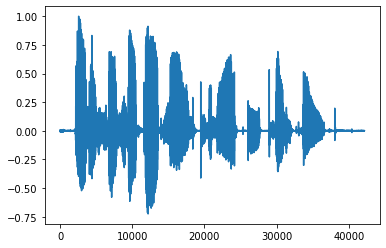

In [24]:
plt.plot(wave_s[0])

In [21]:
torch.save(model, '0504_codec_nosp2_1563.model') 

In [ ]:
entropy_prob(prob)

In [ ]:
plt.hist(arg_s.flatten().cpu().data)

In [48]:
def cal_entropy(arg):
    
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
        
    return entropy

tensor([33, 38, 38,  ..., 38, 38, 38], device='cuda:0')

In [56]:
counter = collections.Counter(arg_s.flatten().cpu().data.numpy())

In [58]:
cal_entropy(arg_s.flatten().cpu().data.numpy())

1.0583550501686436

In [16]:
def get_n_params(model):
    count = 0
    for param in list(model.parameters()):
        nn = 1
        for s in list(param.size()):
            nn = nn*s
        count += nn
    return count
get_n_params(model)

7885004

In [13]:
entropy

4.624884299598462

In [16]:
max_sdr

12.688108

In [ ]:
max_rs

In [18]:
# torch.save(model,'0503codec_sp1_1391.model')

In [26]:
ipd.Audio(max_rs[0].cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0504_codec_nosp2_1563x.wav', max_rs[0].cpu().data.numpy()[0], sr = 16000)

In [29]:
ipd.Audio(max_rs[1].cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0504_codec_nosp2_1563rx.wav', max_rs[1].cpu().data.numpy()[0], sr = 16000)

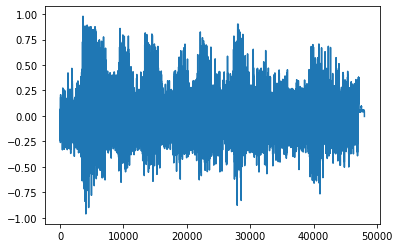

In [18]:
plt.plot(max_rs.cpu().data.numpy()[0])

In [28]:
ipd.Audio('0503codec_sp4_1391rx.wav', rate=16000)

In [ ]:
ipd.Audio(max_rs[0].cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0330coding12_80r.wav', max_rs[0].cpu().data.numpy()[0], sr = 16000)

In [15]:
ipd.Audio((max_rs[0]+max_rs[1]).cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0327Mask12_24rx.wav', (max_rs[0]+max_rs[1]).cpu().data.numpy()[0], sr = 16000)

In [21]:
ipd.Audio(max_rs.cpu().data.numpy()[0], rate = 16000)
# librosa.output.write_wav('0326noMask11_6r.wav', max_rs.cpu().data.numpy()[0], sr = 16000)

In [ ]:
criterion(outputs, data)

In [ ]:
import matplotlib.pyplot as plt
plt.hist(arg.data.cpu().numpy().flatten())

## Listenning Test

In [12]:
def load_trim(wavpath, n, overlap=64):
    
    window = np.hamming(overlap*2) 
    window = np.concatenate((window[:overlap],np.ones(512-overlap*2),window[overlap:]))
    window = window.reshape(1,-1)
    window = window.astype(np.float32)
    
    try:
        c, cr = librosa.load(wavpath, sr = None)
        c /= np.std(c)
    except OSError:
        print('errorfile:',wavpath)
    
    n = n[len(n)//2:len(n)//2+len(c)]
    n = n/np.std(n)
    n /= max(c)
    c /= max(c)
    x = c + n
    
    c_l = []
    x_l = []
    
    for i in range(0, len(c), 512 - overlap):
        if i + 512 > len(c):
            break
        c_l.append(c[i:i+512])
        x_l.append(x[i:i+512])
    c_l = np.array(c_l)
    x_l = np.array(x_l)
    c = c[:len(c_l)*(512-overlap)+overlap]
    x = x[:len(c)]
    
    c_l = c_l * window
    x_l = x_l * window

    return c_l, c, x_l, x


def rebuild(output, overlap = 64):
    output = output.cpu()
    len_wav = len(output) * (512 - overlap) + overlap
    wave = torch.zeros(len_wav)
    for i in range(len(output)):
        wave[i*(512-overlap):i*(512-overlap)+512] += output[i]       
    
    return wave

def SDR(s, sr): # input (50, 512), (50, 512)
    
    eps=1e-20
    s = s.cpu().data.numpy()
    sr = sr.cpu().data.numpy()
    sdr = 10*np.log10(np.sum(s**2)/(np.sum((s-sr)**2)+eps)+eps)
    
    return sdr

def SISDR(s,sr,  cuda = False):
    
    eps = 1e-20
    scale = torch.sum(sr * s, dim = 1) / torch.sum(s**2, dim = 1) 
    scale = scale.unsqueeze(dim = 1) # shape - [50,1]
    s = s * scale
    sisdr = torch.mean(10*torch.log10(torch.sum(s**2, dim = 1)/(torch.sum((s-sr)**2, dim=1)+eps)+eps))
    if cuda:
        return torch.mean(sisdr)
    else:
        return torch.mean(sisdr).cpu().data.numpy()




In [13]:
# Compute entropy
import collections
def entropy(arg):
    entropy = 0
    counter = collections.Counter(arg)
    sum_v = sum(counter.values())
    for value in counter.values():
        p = value / sum_v
        entropy += - np.log(p)*p
    return entropy
    
# entropy(x)    

(array([1., 0., 1., 0., 0., 1., 0., 0., 0., 9.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

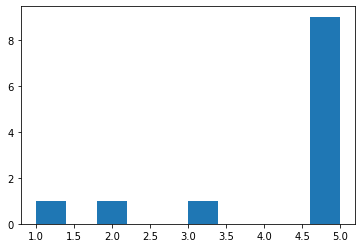

In [14]:
x = [1,2,3,5,5,5,5,5,5,5,5,5]
plt.hist(x)

In [59]:
import IPython.display
import matplotlib.pyplot as plt
import librosa
wavpath1 = '/media/sdc1/Data/timit-wav/train/dr1/fcjf0/sa1.wav'
wavpath2 = '/media/sdc1/Data/timit-wav/train/dr1/fcjf0/sa2.wav'
c1, cr = librosa.load(wavpath1, sr=None)
c1 = c1/max(c1)
c2, cr = librosa.load(wavpath2, sr=None)
c2 = c2/max(c2)
idx = 1
names = ['birds', 'computerkeyboard', 'jungle', 'ocean', 'casino', 'eatingchips', 'machineguns',\
                 'cicadas', 'frogs', 'motorcycles']
noise_path = '/media/sdc1/Data/Duan/{}.wav'.format(names[idx])
n, nr = librosa.load(noise_path, sr=None)
n = n/max(n)
# c2, cr = librosa.load(wavpath2, sr=None)
# c1_, cr = librosa.load(wavpath1)
# c1, c2 = c1/np.max(c1), c2/np.max(c2)
n = n[len(n)//2:len(n)//2+len(c1)]
mixture = n + c1

In [2]:
import torchaudio
waveform, sample_rate = torchaudio.load('test.wav')

In [22]:
waveform.shape

torch.Size([1, 57856])

In [15]:
import torchaudio

In [63]:
import torch
c1 = torch.Tensor(c1)
c2 = torch.Tensor(c2)
length = min(len(c1), len(c2))
c1 = c1[:length]
c2 = c2[:length]
mixture = torch.Tensor(mixture)

In [131]:
c1_melspec1 = torchaudio.transforms.MelSpectrogram(n_fft=512)(c1)
# c2_spec = torchaudio.transforms.MelSpectrogram(n_fft=512)(c2)
c1_spec = torchaudio.transforms.Spectrogram(n_fft=512)(c1)
c2_spec = torchaudio.transforms.Spectrogram(n_fft=512)(c2)


In [133]:
c1_melspec = torchaudio.transforms.MelScale()(c1_spec)
c2_melspec = torchaudio.transforms.MelScale()(c2_spec)

In [136]:
c1_melspec = torchaudio.transforms.MelSpectrogram(n_fft=512)(c1)
c2_melspec = torchaudio.transforms.MelSpectrogram(n_fft=512)(c2)

In [137]:
eps = 1e-20
c1_melspec = torch.log(c1_melspec + eps)
c2_melspec = torch.log(c2_melspec + eps)

In [96]:
c1_spec.imag().cpu().data.numpy().any()

False

In [65]:
x = torch.rand(2,3)
y = torch.rand(2,3)


In [138]:
mse = nn.MSELoss()
mse(c1_melspec, c2_melspec)

tensor(16.8922)

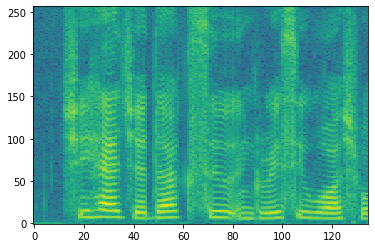

In [78]:
plt.imshow(torch.log(c1_spec), aspect = 'auto', origin = 'lower')

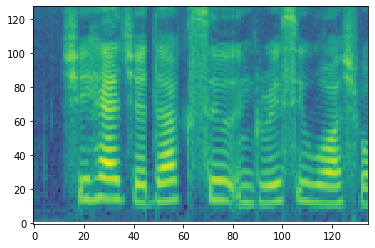

In [77]:
plt.imshow(torch.log(c1_melspec), aspect = 'auto', origin = 'lower')

In [67]:
mse(c1, c2)

tensor(0.0327)

# torchaudio.transforms.MelSpectrogram(n_fft=400)(c1).shape

In [ ]:
mixture = 0.1 * n[len(n)//2:len(n)//2+len(c1)] + c1

In [68]:
IPython.display.Audio(mixture, rate = cr)

In [69]:
# # model = Autoencoder(block = Bottleneck,d = 15, num_m = 32, soft = True).cuda()
# model = torch.load('0304_entropy_control.model')

In [70]:
model.eval()
data = torch.Tensor(trim(mixture)).cuda()
clean = torch.Tensor(trim(c1)).cuda()
s_h, n_h, arg_s, arg_n = model(data, soft = False)

In [1]:
noise = torch.Tensor(trim(n)).cuda()
SDR(clean, n_h)

NameError: name 'torch' is not defined

In [57]:
data = torch.Tensor(trim(mixture)).cuda()
clean = torch.Tensor(trim(c1)).cuda()

In [53]:
dist = arg_n.data.cpu().numpy().flatten()
entropy(dist)

AttributeError: 'NoneType' object has no attribute 'data'

In [54]:
# IPython.display.Audio(mixture, rate = cr)

In [74]:
IPython.display.Audio(rebuild(n_h), rate = cr)

In [ ]:
data = torch.Tensor(trim(c1[:length])).cuda()
output1, arg1 = model.test_hard_qtz(data)
data = torch.Tensor(trim(c2[:length])).cuda()
output2, arg2 = model.test_hard_qtz(data)

In [ ]:
IPython.display.Audio(rebuild(output1)/max(c1)+rebuild(output2)/max(c2), rate = cr)

In [ ]:
muspath1 = '/media/sdc1/Data/ETRI_Music/1349-00002-RFO.wav'
m1, mr = librosa.load(muspath1)

In [ ]:
plt.plot(m1)

In [ ]:
dist1 = arg1.data.cpu().numpy().flatten()
dist2 = arg2.data.cpu().numpy().flatten()
dist_stk = np.hstack((dist1, dist2))

In [ ]:
dist_stk.shape

In [ ]:
print(entropy(dist1), entropy(dist2), entropy(dist), entropy(dist_stk))

In [ ]:
entropy(arg)

In [ ]:
x.reshape(-1, 3)